In [2]:
import numpy as np
import cv2
from random import randint
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
import time
import pandas as pd
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from enum import Enum
from tensorflow.keras.layers import (Activation, Conv2D, Dense, Dropout,
                                     Flatten, MaxPooling2D, LSTM)

In [3]:
class Classes(Enum):
    aviao = 1
    banana = 2
    abelha = 3
    copo_de_cafe = 4
    carangueijo = 5
    guitarra = 6,
    hamburguer = 7,
    coelho = 8,
    caminhao = 9,
    guarda_chuva = 10

In [4]:
NUMERO_DE_AMOSTRAS = 1200
NUMERO_DE_CLASSES = len(Classes)

In [5]:
def load_quickdrow_images_from_npy(npy_file_directory :str) -> list[list[int]]:
    images = np.load(npy_file_directory)
    return images

def plot_quickdraw_image(image_array: list[int]) -> None:
    image_inverted_reshaped = cv2.bitwise_not(image_array).reshape(28,28)
    plt.imshow(image_inverted_reshaped, cmap='gray')
    plt.show()

def plot_random_quickdraw_image(images_array: list[list[int]]) -> None:
    image_random_position = randint(0, len(images_array))
    plot_quickdraw_image(images_array[image_random_position])

# PROCESS UTILS

def generate_x_y_from_dataset(data, classification, data_matrix, x, y):
    data_sample = data[:NUMERO_DE_AMOSTRAS]
    for sample in data_sample:
        sample_processed = sample.astype(np.float32)
        sample_processed /= 255.0
        x.append(sample_processed.reshape((28, 28, 1)))
        y.append(data_matrix[classification])

# KERAS MODELS

def create_cnn_model(optimizer = 'adam'):
    modelo = Sequential()
    modelo.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(28,28,1)))

    modelo.add(Conv2D(64, (3, 3), activation='relu'))
    modelo.add(MaxPooling2D(pool_size=(2, 2)))
    modelo.add(Dropout(0.5))                 
    modelo.add(Flatten())
    modelo.add(Dense(64, activation='relu'))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(64, activation='relu'))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(64, activation='relu'))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(NUMERO_DE_CLASSES, activation='softmax'))
    modelo.compile(optimizer = optimizer, loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

    return modelo
    
def create_rnn_model(optimizer = 'adam'):
    modelo = Sequential()
    modelo.add(LSTM(64, input_shape=(28, 28),
              activation="relu", return_sequences=True))
    modelo.add(LSTM(32, activation="relu"))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(32, activation="relu"))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(32, activation='relu'))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(NUMERO_DE_CLASSES, activation="softmax"))
    modelo.compile(optimizer=optimizer, loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return modelo

def create_rnn_best_model():
    modelo = Sequential()
    modelo.add(LSTM(64, input_shape=(28, 28),
              activation="relu", return_sequences=True))
    modelo.add(LSTM(32, activation="relu"))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(32, activation="relu"))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(32, activation='relu'))
    modelo.add(Dropout(0.5))
    modelo.add(Dense(NUMERO_DE_CLASSES, activation="softmax"))
    modelo.compile(optimizer='RMSprop', loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return modelo

def generate_excel_metrics_crossvalidate(x, y, build_model, file_name, n_splits = 10):
    accuracy_values = []
    precision_values = []
    recall_values = []
    f1_values = []
    fit_time_values = []
    score_time_values = []
    kf = KFold(n_splits=n_splits, shuffle=True)

    y_single = np.argmax(y, axis=1)
    for i in range(0, 30):
        print(f"===============================================Actual cross validate: {i+1}==================================================================")
        actual_acc = []
        actual_precision = []
        actual_recall = []
        actual_f1 = []
        actual_fit_time = []
        actual_predict_time = []
        for train_index, val_index in kf.split(x):
            model = KerasClassifier(build_fn=build_model, epochs=30, verbose=0)
            fit_time = time.time()
            model.fit(x[train_index], y[train_index])
            end_fit_time = time.time()

            pred_time = time.time()
            pred = model.predict(x[val_index])
            end_pred_time = time.time()

            actual_acc.append(accuracy_score(y_single[val_index], pred))
            actual_precision.append(precision_score(y_single[val_index], pred, average='weighted'))
            actual_recall.append(recall_score(y_single[val_index], pred, average='weighted'))
            actual_f1.append(f1_score(y_single[val_index], pred, average='weighted'))
            actual_fit_time.append(end_fit_time - fit_time)
            actual_predict_time.append(end_pred_time - pred_time)

        accuracy_values.append(np.mean(actual_acc))
        precision_values.append(np.mean(actual_precision))
        recall_values.append(np.mean(actual_recall))
        f1_values.append(np.mean(actual_f1))
        fit_time_values.append(np.mean(actual_fit_time))
        score_time_values.append(np.mean(actual_predict_time))

    model_data = pd.DataFrame(data={"Acurácia": accuracy_values,
                               "Precisão": precision_values,
                               "Recall": recall_values,
                               "F1": f1_values,
                               "Tempo de treinamento": fit_time_values,
                               "Tempo de classificação": score_time_values})

    model_data.to_excel(f"metrics/{file_name}")

In [6]:
# Carregando imagens
images_airplane = load_quickdrow_images_from_npy('data/full_numpy_bitmap_airplane.npy')
images_banana = load_quickdrow_images_from_npy('data/full_numpy_bitmap_banana.npy')
images_bee = load_quickdrow_images_from_npy('data/full_numpy_bitmap_bee.npy')
images_cofee_cup = load_quickdrow_images_from_npy('data/full_numpy_bitmap_coffee cup.npy')
images_crab = load_quickdrow_images_from_npy('data/full_numpy_bitmap_crab.npy')
images_guitar = load_quickdrow_images_from_npy('data/full_numpy_bitmap_guitar.npy')
images_hamburguer = load_quickdrow_images_from_npy('data/full_numpy_bitmap_hamburger.npy')
images_rabbit = load_quickdrow_images_from_npy('data/full_numpy_bitmap_rabbit.npy')
images_truck = load_quickdrow_images_from_npy('data/full_numpy_bitmap_truck.npy')
images_umbrella = load_quickdrow_images_from_npy('data/full_numpy_bitmap_umbrella.npy')

In [13]:
# Processamento dos dados
classes_dict = {}
sequencial = 0

for classe in Classes._member_names_:
    classificacao_atual = np.zeros(NUMERO_DE_CLASSES)
    classificacao_atual[sequencial] = 1
    classes_dict[classe] = classificacao_atual
    sequencial += 1

# Montando variaveis x e y
x = []
y = []

generate_x_y_from_dataset(images_airplane, Classes.aviao.name, classes_dict, x, y)
generate_x_y_from_dataset(images_banana, Classes.banana.name, classes_dict, x, y)
generate_x_y_from_dataset(images_bee, Classes.abelha.name, classes_dict, x, y)
generate_x_y_from_dataset(images_cofee_cup, Classes.copo_de_cafe.name, classes_dict, x, y)
generate_x_y_from_dataset(images_crab, Classes.carangueijo.name, classes_dict, x, y)
generate_x_y_from_dataset(images_guitar, Classes.guitarra.name, classes_dict, x, y)
generate_x_y_from_dataset(images_hamburguer, Classes.hamburguer.name, classes_dict, x, y)
generate_x_y_from_dataset(images_rabbit, Classes.coelho.name, classes_dict, x, y)
generate_x_y_from_dataset(images_truck, Classes.caminhao.name, classes_dict, x, y)
generate_x_y_from_dataset(images_umbrella, Classes.guarda_chuva.name, classes_dict, x, y)

# Separando dados para treino e teste

X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(x,
                                                                  y,
                                                                  test_size = 0.1,
                                                                  random_state = 0)

X_treinamento = np.array(X_treinamento)
X_teste = np.array(X_teste)
y_treinamento = np.array(y_treinamento)
y_teste = np.array(y_teste)
print("Quantidade de dados para treino: ", len(X_treinamento))
print(len(x[0]))


Quantidade de dados para treino:  10800
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


Melhor score: 0.880741 usando {'optimizer': 'Adam'}
0.835926 (0.022997) com: {'optimizer': 'SGD'}
0.880741 (0.014459) com: {'optimizer': 'Adam'}
0.876481 (0.006491) com: {'optimizer': 'Adamax'}
0.866389 (0.009975) com: {'optimizer': 'RMSprop'}
0.193241 (0.037156) com: {'optimizer': 'Adadelta'}
===============================================Actual cross validate: 1==================================================================
===============================================Actual cross validate: 2==================================================================
===============================================Actual cross validate: 3==================================================================
===============================================Actual cross validate: 4==================================================================
===============================================Actual cross validate: 5==================================================================
===============

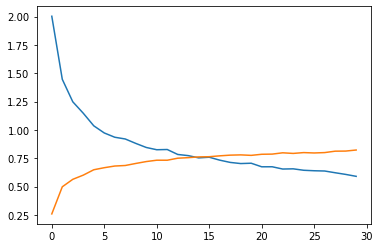

In [35]:
# Treinando a rede neural CNN(Convolutional Neural Network)

cnn_model = KerasClassifier(build_fn=create_cnn_model, epochs=30, verbose=0)

# Aplicando GridSearchCV para escolha dos melhores parametros

optimizer = ['SGD', 'Adam', 'Adamax', 'RMSprop', 'Adadelta']

param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=cnn_model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_treinamento, y_treinamento)

best_history = grid_result.best_estimator_.model.history.history 
plt.plot(best_history['loss'])
plt.plot(best_history['accuracy'])
plt.savefig('metrics/cnn/val_loss_acuracy_chart.png')

grid_result.best_estimator_.model.save('model/cnn_model.h5')

print("Melhor score: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
medias_scores = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parametros = grid_result.cv_results_['params']
for media_score, stdev, parametro in zip(medias_scores, stds, parametros):
    print("%f (%f) com: %r" % (media_score, stdev, parametro))

In [ ]:
generate_excel_metrics_crossvalidate(X_treinamento, y_treinamento, create_cnn_model, "cnn/cnn.xlsx")

Melhor score: 0.748426 usando {'optimizer': 'RMSprop'}
0.314815 (0.117821) com: {'optimizer': 'SGD'}
0.725185 (0.031104) com: {'optimizer': 'Adam'}
0.606667 (0.049147) com: {'optimizer': 'Adamax'}
0.748426 (0.018536) com: {'optimizer': 'RMSprop'}
0.100185 (0.017735) com: {'optimizer': 'Adadelta'}


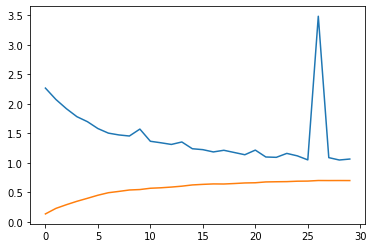

In [120]:
# Treinando a rede neural RNN(Convolutional Neural Network)

rnn_model = KerasClassifier(build_fn=create_rnn_model, epochs=30, verbose=0)

# Aplicando GridSearchCV para escolha dos melhores parametros

optimizer = ['SGD', 'Adam', 'Adamax', 'RMSprop', 'Adadelta']

param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=rnn_model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_treinamento, y_treinamento)

best_history = grid_result.best_estimator_.model.history.history 
plt.plot(best_history['loss'])
plt.plot(best_history['accuracy'])
plt.savefig('metrics/rnn/val_loss_acuracy_chart.png')

grid_result.best_estimator_.model.save('model/rnn_model.h5')

print("Melhor score: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
medias_scores = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
parametros = grid_result.cv_results_['params']
for media_score, stdev, parametro in zip(medias_scores, stds, parametros):
    print("%f (%f) com: %r" % (media_score, stdev, parametro))



In [122]:
generate_excel_metrics_crossvalidate(X_treinamento, y_treinamento, create_rnn_best_model, "rnn/rnn.xlsx")

===============================================Actual cross validate: 1==================================================================
===============================================Actual cross validate: 2==================================================================
===============================================Actual cross validate: 3==================================================================
===============================================Actual cross validate: 4==================================================================
===============================================Actual cross validate: 5==================================================================
===============================================Actual cross validate: 6==================================================================
===============================================Actual cross validate: 7==================================================================
==================================